In [1]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from  torch.distributions import normal , MultivariateNormal
import GPE_ensemble as GPE

dtype = torch.float
device = torch.device("cpu")

import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
#from GPErks.gp.data.dataset import Dataset
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from torchmetrics import MeanSquaredError, R2Score
#from GPErks.gp.experiment import GPExperiment
#from GPErks.train.emulator import GPEmulator
#from GPErks.perks.inference import Inference
#from GPErks.train.early_stop import NoEarlyStoppingCriterion
#from GPErks.train.early_stop import (
#    GLEarlyStoppingCriterion,
#    PQEarlyStoppingCriterion,
#    UPEarlyStoppingCriterion,
#)
#from GPErks.train.early_stop import PkEarlyStoppingCriterion



%matplotlib inline
%load_ext autoreload
%autoreload 2

# set logger and enforce reproducibility
#from GPErks.log.logger import get_logger
#from GPErks.utils.random import set_seed
#log = get_logger()
seed = 7
#set_seed(seed)
from time import process_time 
import scipy
from scipy.optimize import minimize

$y=f(x)+\epsilon$

$f(x)\sim GP(\mu, k)$

For some $y^*$ want to find $x^*$. Let $q(x)$ be a candidate distribution for $x^*$, in this case assume $q(x)\sim N(m,\Sigma)$.

Want to maximise the evidence lower bound (ELBO) with respect to $q$. 

To calibrate three model parameters we need to optimise over $m$ and and the 6 unique elements $\Sigma$ (9 parameters total).

$ELBO = \mathbb{E}_q[log(p(y,x))]-\mathbb{E}_q[log(q(x))] = \mathbb{E}_q[log(p(y|x)p(x)]-\mathbb{E}_q[log(q(x)]$

$= \int q(x)log(p(x)\Pi p(y_i|x))dx -\mathbb{E}_q[log(q(x))]dx$

$\approx \frac{1}{n}\sum log(p(x_j)\Pi p(y_i|x_j)) -\mathbb{E}_q[log(q(x))]$, $x_i$ sampled from $q$.

$\mathbb{E}_q[log(q(x))] = -\frac{3}{2}(1+log(2\pi)) -\frac{1}{2}log(det(\Sigma))$

Log likelihood
$y=f(x)+\epsilon$

$f|x \sim N(\mu(x), k(x,x))$

$y|x \sim N(\mu(x),\sigma^2 + k(x,x))$

$log p(y|x) \propto -\frac{1}{2}log(\sigma^2 + k(x,x))-\frac{1}{2(\sigma^2 + k(x,x))}(y-\mu(x))^2$ 

So what we want is:

$log p(y|x) \propto -\frac{1}{2}log(\sigma^2 + k(x,x))-\frac{1}{2(\sigma^2 + k(x,x))}(y-\mu(x))^2$ 

and what I'm currently using is

$log p(f|x) \propto -\frac{1}{2}log(k(x,x))-\frac{1}{2(k(x,x))}(y-\mu(x))^2$

# $y=-a(x-b)^2+c$

In [2]:
dtype = torch.float32
device = torch.device("cpu")

In [3]:
def ELBO(m,s2,x,emulator,y,prior_mean,prior_cov,obs_error):
    
    L=torch.zeros((x.shape[0],x.shape[0]))
    L=L.diagonal_scatter(s2)
    
    #L[1,0]=param[6]
   # L[2,0]=param[7]
   # L[2,1] =param[8]
    covar = L.matmul(L.T)
    z=L.matmul(x)+m
    
    z=z.T 
    
    mc_int = (emulator.ensemble_log_likelihood_obs_error(z,y,obs_error)+x_prior(z,prior_mean,prior_cov)[:,None]).mean()
        #mc_int +=-np.log(np.sum(((emulator.predict(z.iloc[[i]]).detach().numpy()-y.values)**2)))+np.log(x_prior(z.iloc[[i]],prior_mean,prior_cov))
        #mc_int += (np.sum(np.log(emulator.ensemble_likelihood(z.iloc[[i]],y)))+np.log(x_prior(z.iloc[[i]],prior_mean,prior_cov)))
    
    lb = mc_int - q_prior(covar)
    
    #print(mc_int/x.shape[1])
    #print(-q_prior(covar))
    #print(np.mean(z,axis=0))
    #print(-lb)
    return -lb
    

def ELBO_fun(m,s2,x,function,y,prior_mean,prior_cov,obs_error):
    
    L=torch.zeros((x.shape[0],x.shape[0]))
    L=L.diagonal_scatter(s2)
    
    #L[1,0]=param[6]
   # L[2,0]=param[7]
   # L[2,1] =param[8]
    covar = L.matmul(L.T)
    z=L.matmul(x)+m
   
    z=z.T 
    
    mc_int = (f_likelihood(z,y,function,obs_error)+x_prior(z,prior_mean,prior_cov)[:,None]).mean()
        #mc_int +=-np.log(np.sum(((emulator.predict(z.iloc[[i]]).detach().numpy()-y.values)**2)))+np.log(x_prior(z.iloc[[i]],prior_mean,prior_cov))
        #mc_int += (np.sum(np.log(emulator.ensemble_likelihood(z.iloc[[i]],y)))+np.log(x_prior(z.iloc[[i]],prior_mean,prior_cov)))
    
    lb = mc_int - q_prior(covar)
    
    #print(mc_int/x.shape[1])
    #print(-q_prior(covar))
    #print(np.mean(z,axis=0))
    #print(-lb)
    return -lb

def x_prior(x,mean,cov):

    #var = scipy.stats.multivariate_normal(mean=mean, cov=cov)
    #val1 = var.pdf(x)
    dist = MultivariateNormal(loc=mean, covariance_matrix=cov)
    val = dist.log_prob(x)
    return val

def q_prior(covar):
    qp = -(covar.shape[0]/2)*(1+torch.log(torch.tensor(2*torch.pi)))-0.5*torch.log(torch.linalg.det(covar))
    return qp

def f_likelihood(x,y,f,sigma2):
    #x,f=emulator.normalise_test_data(x,f(x))
    #x,y=emulator.normalise_test_data(x,y)
    
    likelihood_manual=-0.5*((f(x) - y)**2)/(sigma2)- 0.5*torch.log(torch.tensor(2*np.pi))-0.5*torch.log(sigma2)
    return likelihood_manual

def f_likelihood2(x,y,f,sigma2):
    
    likelihood_manual=-0.5*((f(x) - y)**2)/(sigma2)- 0.5*np.log(2*np.pi)-0.5*np.log(sigma2)
    return likelihood_manual

In [4]:
p=5

In [5]:
rl = -10
ru=20

In [6]:
obs_error = 0.001

In [7]:
x=torch.linspace(rl,ru,p)

In [8]:
x

tensor([-10.0000,  -2.5000,   5.0000,  12.5000,  20.0000])

In [9]:
a=0.05
b=5
c=1

In [10]:
def quad(x):
    y = - a*(x-c)**2 +b
    return y

In [11]:
y = quad(x) #+ torch.random.normal(0,obs_error,p)

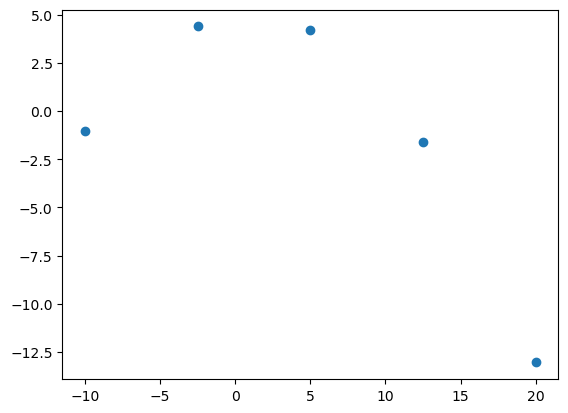

In [12]:
plt.plot(x,y,'o')

In [13]:
emulator = GPE.ensemble(x[:,None],y[:,None],mean_func="constant",training_iter=500)

0


In [14]:
tp = 500
dx = (ru-rl)/tp
x_test = torch.linspace(rl,ru,tp)


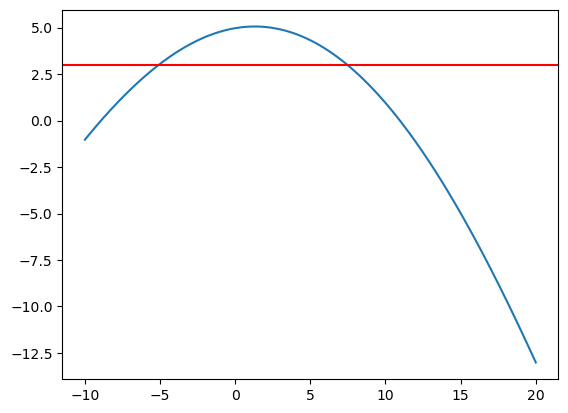

In [15]:
plt.plot(x_test,emulator.predict(x_test).detach().numpy())
plt.axhline(y=3, color='r', linestyle='-')

In [16]:
emulator.training_output_STD

tensor([7.0842])

In [17]:
prior_mean=torch.tensor([0])
prior_cov = torch.tensor([10])*torch.eye(1)
obs_error = torch.tensor([0.1])
y_cal = torch.tensor([3])

In [18]:
### initialize the variational parameters
m = torch.full((), 1.,dtype=dtype, requires_grad=True, device=device)
s2 = torch.full((1,),3.,dtype=dtype, requires_grad=True, device=device)


# Samples fixed here - but try adding them into the loop
nsamples = 1000
#Z = torch.randn((nsamples), dtype=dtype, requires_grad=False, device=device)

learning_rate = 1e-2
for t in range(1000):
    Z = torch.randn((nsamples), dtype=dtype, requires_grad=False, device=device)
    Z=Z[None,:]
    #negELBO = -Eloglike(m,log_s2)+KL(log_s2)
    
    negELBO = ELBO(m,s2,Z,emulator,y_cal[:,None],prior_mean,prior_cov,obs_error)
    
    if t % 100 == 99:
        print(t, negELBO.item(), 'm=', m.item(), 's2=', s2.pow(2).item())
    
    # Use autograd to compute the backward pass. This call will compute the
    # gradient of loss with respect to all Tensors with requires_grad=True.
    # After this call a.grad, b.grad. c.grad and d.grad will be Tensors holding
    # the gradient of the loss with respect to a, b, c, d respectively.
    negELBO.backward()

    # Manually update weights using gradient descent. Wrap in torch.no_grad()
    # because weights have requires_grad=True, but we don't need to track this
    # in autograd.
    with torch.no_grad():
        m -= learning_rate * m.grad
        s2 -= learning_rate * s2.grad
        
        # Manually zero the gradients after updating weights
        m.grad = None
        s2.grad = None
        
print(f'Result: p(x|y) = N({m.item()}, {torch.pow(s2,2).item()}) ')

99 7.693665504455566 m= 0.7134073972702026 s2= 13.183610916137695
199 7.376188278198242 m= 0.482922226190567 s2= 13.091748237609863
299 7.810722351074219 m= 0.24190349876880646 s2= 13.037494659423828
399 7.5121049880981445 m= -0.02666988968849182 s2= 12.492040634155273
499 7.351177215576172 m= -0.32113975286483765 s2= 11.870160102844238
599 6.531836032867432 m= -0.7285391688346863 s2= 10.741351127624512
699 5.985968112945557 m= -1.4406483173370361 s2= 8.52529239654541
799 2.3272690773010254 m= -3.0149784088134766 s2= 3.3463077545166016
899 -2.374116897583008 m= -4.66789436340332 s2= 0.381348580121994
999 -2.5116381645202637 m= -4.868817329406738 s2= 0.29338568449020386
Result: p(x|y) = N(-4.869075775146484, 0.29290637373924255) 


In [19]:
### initialize the variational parameters
m_fun = torch.full((), 0.,dtype=dtype, requires_grad=True, device=device)
s2_fun = torch.full((1,),1,dtype=dtype, requires_grad=True, device=device)


# Samples fixed here - but try adding them into the loop
nsamples = 1000
#Z = torch.randn((nsamples), dtype=dtype, requires_grad=False, device=device)

learning_rate = 1e-2
for t in range(1000):
    Z = torch.randn((nsamples), dtype=dtype, requires_grad=False, device=device)
    Z=Z[None,:]
    #negELBO = -Eloglike(m,log_s2)+KL(log_s2)
    
    negELBO = ELBO_fun(m_fun,s2_fun,Z,quad,y_cal[:,None],prior_mean,prior_cov,obs_error)
    
    if t % 100 == 99:
        print(t, negELBO.item(), 'm=', m_fun.item(), 's2=', s2_fun.pow(2).item())
    
    # Use autograd to compute the backward pass. This call will compute the
    # gradient of loss with respect to all Tensors with requires_grad=True.
    # After this call a.grad, b.grad. c.grad and d.grad will be Tensors holding
    # the gradient of the loss with respect to a, b, c, d respectively.
    negELBO.backward()

    # Manually update weights using gradient descent. Wrap in torch.no_grad()
    # because weights have requires_grad=True, but we don't need to track this
    # in autograd.
    with torch.no_grad():
        m_fun -= learning_rate * m_fun.grad
        s2_fun -= learning_rate * s2_fun.grad
        #print(m_fun.grad)
        #print(s2_fun.grad)
        # Manually zero the gradients after updating weights
        m_fun.grad = None
        s2_fun.grad = None
        
print(f'Result: p(x|y) = N({m_fun.item()}, {torch.pow(s2_fun,2).item()}) ')

99 11.775816917419434 m= -1.9376845359802246 s2= 6.152629375457764
199 5.00582218170166 m= -4.055490970611572 s2= 1.350148320198059
299 2.9366159439086914 m= -5.071960926055908 s2= 0.2806800901889801
399 2.987452507019043 m= -5.1255059242248535 s2= 0.2597982883453369
499 3.0071024894714355 m= -5.1305437088012695 s2= 0.2647189199924469
599 2.976308822631836 m= -5.124831199645996 s2= 0.2633225917816162
699 2.9704389572143555 m= -5.12282657623291 s2= 0.2621827721595764
799 2.9364147186279297 m= -5.128586292266846 s2= 0.2611948847770691
899 2.96297287940979 m= -5.128802299499512 s2= 0.26908934116363525
999 2.927567720413208 m= -5.125458240509033 s2= 0.2654160261154175
Result: p(x|y) = N(-5.124967098236084, 0.2669214606285095) 


In [20]:
x_n,x_n1 = emulator.normalise_test_data(x_test,x_test)
c_n = emulator.likelihoods[0](emulator.models[0](x_n)).covariance_matrix

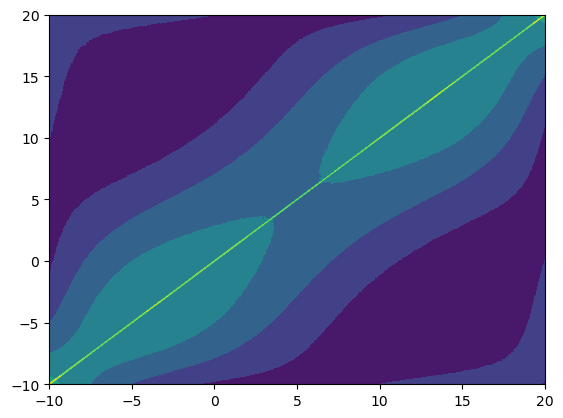

In [21]:
plt.contourf(x_test,x_test,c_n.detach().numpy())

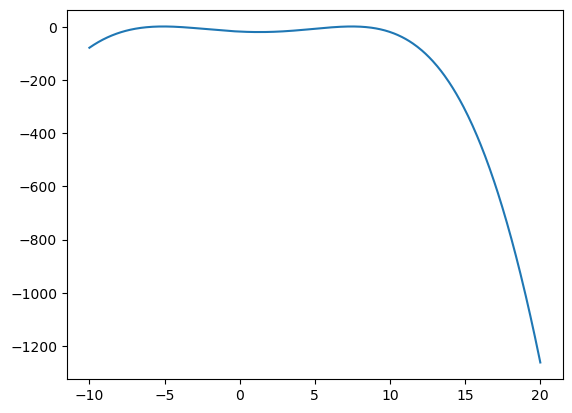

In [22]:
like=(-0.5*((emulator.predict(x_test)-y_cal)**2)/(obs_error+c_n.diag()[:,None])-0.5*torch.log(obs_error+c_n.diag()[:,None])-- 0.5*torch.log(torch.tensor(2*np.pi))).detach().numpy()
plt.plot(x_test,like)

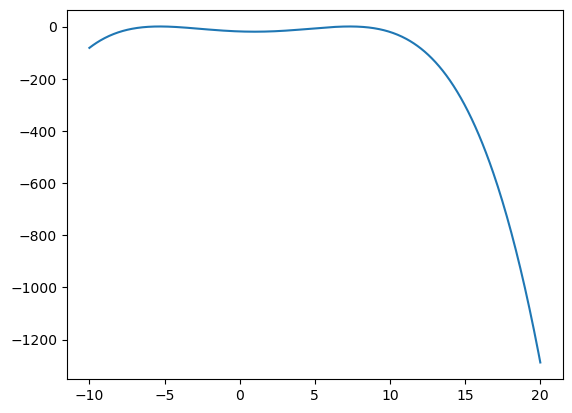

In [23]:
like = -0.5*(quad(x_test)-y_cal)**2/obs_error-0.5*np.log(obs_error)- 0.5*torch.log(torch.tensor(2*np.pi))
plt.plot(x_test,like)

/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_82642/3715141962.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3618.)
  plt.plot(f_likelihood(x_test,y_cal,quad,obs_error).T)


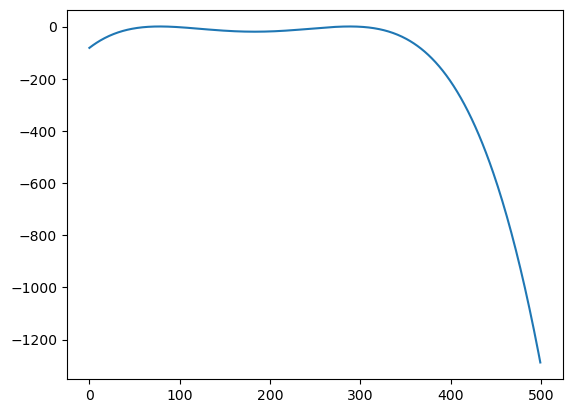

In [24]:
plt.plot(f_likelihood(x_test,y_cal,quad,obs_error).T)

In [25]:
f_likelihood(x_test,y_cal,quad,obs_error).T.mean()

tensor(-149.6062)

In [26]:
emulator.normalise_test_data(torch.tensor([1.1]),torch.tensor([1]))

(tensor([-0.3289]), tensor([0.3423]))

In [27]:
emulator.normalise_test_data(torch.tensor([-1]),torch.tensor([0]))

(tensor([-0.5060]), tensor([0.2012]))

In [28]:
torch.sum(f_likelihood(x_test,y_cal,quad,obs_error))

tensor(-74803.0781)

In [29]:
torch.sum(emulator.ensemble_log_likelihood_obs_error(x_test,y_cal[:,None],obs_error))

tensor(-67916.0156, grad_fn=<SumBackward0>)

In [30]:
emulator.likelihoods[0](emulator.models[0](Z.T)).covariance_matrix.diag()

tensor([1.1843e-03, 1.2282e-03, 1.1843e-03, 1.2721e-03, 1.1672e-03, 1.1061e-03,
        1.1881e-03, 1.1805e-03, 1.1748e-03, 1.1118e-03, 1.2415e-03, 1.0909e-03,
        1.1977e-03, 1.0928e-03, 1.2091e-03, 1.1653e-03, 5.2432e-03, 1.1519e-03,
        1.1099e-03, 1.6226e-02, 1.1729e-03, 1.2320e-03, 1.1881e-03, 1.5124e-03,
        2.4966e-03, 1.1347e-03, 1.1214e-03, 1.0985e-03, 1.1023e-03, 8.4418e-03,
        1.0890e-03, 1.3007e-03, 1.3484e-03, 1.1099e-03, 2.7593e-02, 1.2148e-03,
        1.2396e-03, 1.2339e-03, 1.1195e-03, 1.2396e-03, 1.1920e-03, 1.2301e-03,
        1.5200e-03, 1.2339e-03, 2.0731e-03, 1.2339e-03, 1.2320e-03, 1.1996e-03,
        8.3826e-01, 1.4839e-02, 1.5217e-02, 1.2187e-03, 1.1920e-03, 1.1252e-03,
        1.1977e-03, 1.2339e-03, 1.1862e-03, 1.1309e-03, 1.0890e-03, 1.0909e-03,
        8.5238e-03, 1.0909e-03, 1.1023e-03, 1.1042e-03, 1.1805e-03, 1.1843e-03,
        1.2187e-03, 5.5998e-02, 1.0890e-03, 6.4086e-03, 1.1958e-03, 1.2377e-03,
        1.2148e-03, 1.1614e-03, 4.0415e-

In [31]:
dist = normal.Normal(loc=m_fun, scale=s2_fun)
val = torch.exp(dist.log_prob(x_test))

In [32]:
likelihood = torch.exp(emulator.ensemble_log_likelihood_obs_error(x_test,y_cal[:,None],obs_error))

In [33]:
prior_mean

tensor([0])

In [34]:
dist_prior = normal.Normal(loc=prior_mean, scale=torch.sqrt(torch.tensor([5])))
val_prior = torch.exp(dist_prior.log_prob(x_test))

In [35]:
posterior = likelihood*val_prior / (torch.sum(likelihood*val_prior)*dx)

In [36]:
true_likelihood= (f_likelihood(x_test,y_cal,quad,obs_error))

In [37]:
true_likelihood=torch.exp(true_likelihood)

In [38]:
true_posterior = true_likelihood.squeeze()*val_prior / (torch.sum(true_likelihood.squeeze()*val_prior)*0.2)

In [39]:
true_likelihood2= np.array(f_likelihood2(x_test,y_cal,quad,obs_error))

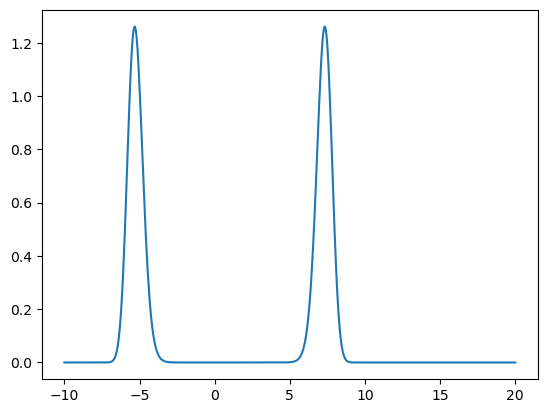

In [40]:
plt.plot(x_test.detach().numpy(),np.exp(true_likelihood2))

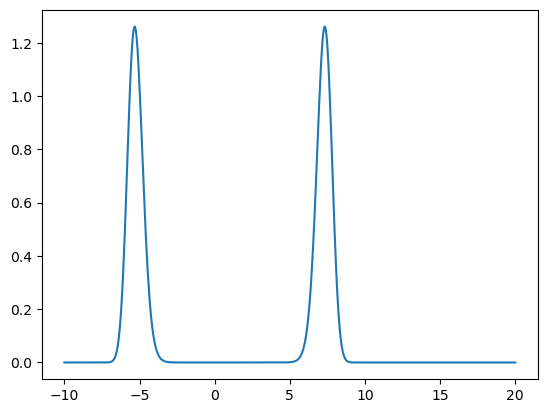

In [41]:
plt.plot(x_test.detach().numpy(),true_likelihood.detach().numpy())

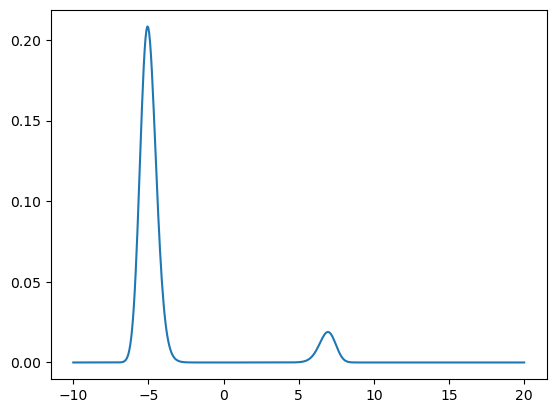

In [42]:
plt.plot(x_test.detach().numpy(),true_posterior.T.detach().numpy())

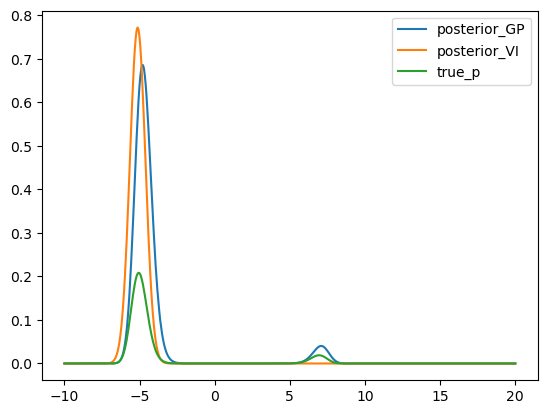

In [43]:
plt.plot(x_test.detach().numpy(),posterior.detach().numpy().T)
plt.plot(x_test.detach().numpy(),val.detach().numpy())
plt.plot(x_test.detach().numpy(),true_posterior.detach().numpy().T)
plt.legend(['posterior_GP','posterior_VI','true_p'])

In [44]:
obs_errors = torch.tensor([1,0.5,0.1,0.05,0.01])
posterior_GPE = torch.zeros((x_test.shape[0],obs_errors.shape[0]))
posterior_VI = torch.zeros((x_test.shape[0],obs_errors.shape[0]))
posterior_VI_fun = torch.zeros((x_test.shape[0],obs_errors.shape[0]))
posterior_True = torch.zeros((x_test.shape[0],obs_errors.shape[0]))

In [45]:
for j,obs_error in enumerate(obs_errors):
    #result = minimize(ELBO, [1,1], args = (xx,emulator,y_test,prior_mean,prior_covar,x.columns,obs_error),method = 'Nelder-Mead',tol=1e-6)
    #var = scipy.stats.multivariate_normal(mean=(result.x[0]), cov=result.x[1]**2)
    #posterior_VI[:,j] = var.pdf(x_test)
    
    ### initialize the variational parameters
    m = torch.full((), 0.,dtype=dtype, requires_grad=True, device=device)
    s2 = torch.full((1,),3.,dtype=dtype, requires_grad=True, device=device)


    # Samples fixed here - but try adding them into the loop
    nsamples = 1000
    #Z = torch.randn((nsamples), dtype=dtype, requires_grad=False, device=device)

    learning_rate = 1e-2
    for t in range(5000):
        Z = torch.randn((nsamples), dtype=dtype, requires_grad=False, device=device)
        Z=Z[None,:]
        #negELBO = -Eloglike(m,log_s2)+KL(log_s2)

        #negELBO = ELBO(m,s2,Z,emulator,y_cal[:,None],prior_mean,prior_cov,obs_error)
        negELBO = ELBO_fun(m,s2,Z,quad,y_cal[:,None],prior_mean,prior_cov,obs_error)
        if t % 100 == 99:
            print(t, negELBO.item(), 'm=', m.item(), 's2=', s2.item())

        # Use autograd to compute the backward pass. This call will compute the
        # gradient of loss with respect to all Tensors with requires_grad=True.
        # After this call a.grad, b.grad. c.grad and d.grad will be Tensors holding
        # the gradient of the loss with respect to a, b, c, d respectively.
        negELBO.backward()

        # Manually update weights using gradient descent. Wrap in torch.no_grad()
        # because weights have requires_grad=True, but we don't need to track this
        # in autograd.
        with torch.no_grad():
            m -= learning_rate * m.grad
            s2 -= learning_rate * s2.grad

            # Manually zero the gradients after updating weights
            m.grad = None
            s2.grad = None

    print(f'Result: p(x|y) = N({m.item()}, {torch.pow(s2,2).item()}) ')
    
    dist = normal.Normal(loc=m, scale=s2)
    posterior_VI_fun[:,j] = torch.exp(dist.log_prob(x_test))
    
    ### initialize the variational parameters
    m = torch.full((), 0.,dtype=dtype, requires_grad=True, device=device)
    s2 = torch.full((1,),3.,dtype=dtype, requires_grad=True, device=device)
    
    for t in range(5000):
        Z = torch.randn((nsamples), dtype=dtype, requires_grad=False, device=device)
        Z=Z[None,:]
        #negELBO = -Eloglike(m,log_s2)+KL(log_s2)

        negELBO = ELBO(m,s2,Z,emulator,y_cal[:,None],prior_mean,prior_cov,obs_error)
        #negELBO = ELBO_fun(m,s2,Z,quad,y_cal[:,None],prior_mean,prior_cov,obs_error)
        if t % 100 == 99:
            print(t, negELBO.item(), 'm=', m.item(), 's2=', s2.item())

        # Use autograd to compute the backward pass. This call will compute the
        # gradient of loss with respect to all Tensors with requires_grad=True.
        # After this call a.grad, b.grad. c.grad and d.grad will be Tensors holding
        # the gradient of the loss with respect to a, b, c, d respectively.
        negELBO.backward()

        # Manually update weights using gradient descent. Wrap in torch.no_grad()
        # because weights have requires_grad=True, but we don't need to track this
        # in autograd.
        with torch.no_grad():
            m -= learning_rate * m.grad
            s2 -= learning_rate * s2.grad

            # Manually zero the gradients after updating weights
            m.grad = None
            s2.grad = None

    print(f'Result: p(x|y) = N({m.item()}, {torch.pow(s2,2).item()}) ')
    
    dist = normal.Normal(loc=m, scale=s2)
    posterior_VI[:,j] = torch.exp(dist.log_prob(x_test))
    
    likelihood = torch.prod(torch.exp(emulator.ensemble_log_likelihood_obs_error(x_test,y_cal[:,None],obs_error)),axis=0)
    posterior_GPE[:,j] = likelihood*val_prior / (torch.sum(likelihood*val_prior)*dx)
    
    true_likelihood= f_likelihood(x_test,y_cal,quad,obs_error)
    true_likelihood=torch.exp(true_likelihood)
    posterior_True[:,j] = (true_likelihood.squeeze()*val_prior / (torch.sum(true_likelihood.squeeze()*val_prior)*dx)).T
    
    print(j)
    
    

99 2.278585195541382 m= -0.05212314426898956 s2= 3.145289182662964
199 2.2073745727539062 m= -0.08983256667852402 s2= 3.237150192260742
299 2.268650531768799 m= -0.11647338420152664 s2= 3.290325880050659
399 2.3051199913024902 m= -0.13664494454860687 s2= 3.3163387775421143
499 2.2048583030700684 m= -0.1535469889640808 s2= 3.3357760906219482
599 2.248661518096924 m= -0.16843363642692566 s2= 3.3497884273529053
699 2.2795441150665283 m= -0.17770284414291382 s2= 3.346345901489258
799 2.310851573944092 m= -0.18740026652812958 s2= 3.3441641330718994
899 2.2527809143066406 m= -0.19389380514621735 s2= 3.337463617324829
999 2.2512569427490234 m= -0.20533493161201477 s2= 3.348036527633667
1099 2.2795255184173584 m= -0.2107037752866745 s2= 3.3390042781829834
1199 2.297382116317749 m= -0.21912594139575958 s2= 3.334033966064453
1299 2.2790074348449707 m= -0.22661520540714264 s2= 3.332369327545166
1399 2.255082130432129 m= -0.2343498319387436 s2= 3.3331992626190186
1499 2.280644416809082 m= -0.24120

2399 3.167628288269043 m= -0.7693520784378052 s2= 3.206103563308716
2499 3.1473963260650635 m= -0.7950604557991028 s2= 3.1865711212158203
2599 3.2695770263671875 m= -0.8303439617156982 s2= 3.1753387451171875
2699 3.2513856887817383 m= -0.8655917048454285 s2= 3.1587717533111572
2799 3.2925522327423096 m= -0.9046674966812134 s2= 3.147859573364258
2899 3.1571860313415527 m= -0.9404332637786865 s2= 3.121579647064209
2999 3.3422975540161133 m= -0.9803376793861389 s2= 3.1007537841796875
3099 3.135042667388916 m= -1.025747537612915 s2= 3.089601755142212
3199 3.226733446121216 m= -1.0699689388275146 s2= 3.0748982429504395
3299 3.219322681427002 m= -1.117870569229126 s2= 3.057819366455078
3399 3.144869327545166 m= -1.1629366874694824 s2= 3.034104824066162
3499 3.312157154083252 m= -1.2151578664779663 s2= 3.0103957653045654
3599 3.2460362911224365 m= -1.2679920196533203 s2= 2.9736132621765137
3699 3.1223390102386475 m= -1.3332064151763916 s2= 2.9511141777038574
3799 3.2379088401794434 m= -1.3980

4699 2.973313570022583 m= -5.1269307136535645 s2= 0.5134547352790833
4799 2.972688913345337 m= -5.129425525665283 s2= 0.5151404738426208
4899 3.0044119358062744 m= -5.128686428070068 s2= 0.5139673948287964
4999 3.018484115600586 m= -5.124037265777588 s2= 0.5131065249443054
Result: p(x|y) = N(-5.123756408691406, 0.26148518919944763) 
99 6.879958629608154 m= -0.4995061457157135 s2= 3.355835199356079
199 6.477778434753418 m= -1.0176931619644165 s2= 3.1290109157562256
299 5.41539192199707 m= -2.051304340362549 s2= 2.5114567279815674
399 -1.4287806749343872 m= -4.079529762268066 s2= 1.0011706352233887
499 -2.4899158477783203 m= -4.832669258117676 s2= 0.554450511932373
599 -2.518843412399292 m= -4.874565124511719 s2= 0.5399178266525269
699 -2.5206024646759033 m= -4.873708724975586 s2= 0.5431029796600342
799 -2.516920804977417 m= -4.8770599365234375 s2= 0.5433225631713867
899 -2.530994415283203 m= -4.874535083770752 s2= 0.5437921285629272
999 -2.553413152694702 m= -4.8784942626953125 s2= 0.53

1399 -3.74477481842041 m= -4.975134372711182 s2= 0.3894416093826294
1499 -3.6974220275878906 m= -4.972721576690674 s2= 0.3960302472114563
1599 -3.744795322418213 m= -4.969828128814697 s2= 0.39270058274269104
1699 -3.7604925632476807 m= -4.971284866333008 s2= 0.3943529427051544
1799 -3.6983489990234375 m= -4.97245979309082 s2= 0.39566418528556824
1899 -3.749908447265625 m= -4.970330238342285 s2= 0.3996593952178955
1999 -3.702476978302002 m= -4.972218036651611 s2= 0.3956746757030487
2099 -3.7398369312286377 m= -4.973868370056152 s2= 0.39693158864974976
2199 -3.7581450939178467 m= -4.971367835998535 s2= 0.3980379104614258
2299 -3.737844228744507 m= -4.969183921813965 s2= 0.39277926087379456
2399 -3.710692882537842 m= -4.970556259155273 s2= 0.39325588941574097
2499 -3.748380184173584 m= -4.971347808837891 s2= 0.3910266160964966
2599 -3.75632905960083 m= -4.968189239501953 s2= 0.3944457769393921
2699 -3.71003794670105 m= -4.970081329345703 s2= 0.3936672508716583
2799 -3.726478338241577 m= -

3099 -6.010993957519531 m= -5.052498817443848 s2= 0.22257761657238007
3199 -6.027218818664551 m= -5.0464186668396 s2= 0.21994812786579132
3299 -5.9918718338012695 m= -5.051856517791748 s2= 0.2132536768913269
3399 -5.9740495681762695 m= -5.049156188964844 s2= 0.21725380420684814
3499 -6.023089408874512 m= -5.045276165008545 s2= 0.2181062549352646
3599 -5.980152606964111 m= -5.046055793762207 s2= 0.21558819711208344
3699 -5.9715118408203125 m= -5.047834396362305 s2= 0.22265970706939697
3799 -5.985615253448486 m= -5.051805019378662 s2= 0.2173270881175995
3899 -6.015380382537842 m= -5.044151782989502 s2= 0.22186394035816193
3999 -6.0001044273376465 m= -5.042818546295166 s2= 0.2183629274368286
4099 -6.023193359375 m= -5.04615592956543 s2= 0.21693886816501617
4199 -6.018592834472656 m= -5.043289661407471 s2= 0.21814800798892975
4299 -5.996284484863281 m= -5.045860290527344 s2= 0.22248022258281708
4399 -6.023606300354004 m= -5.046684741973877 s2= 0.21962480247020721
4499 -5.992703437805176 m=

In [46]:
l = obs_errors.tolist()
l.append('prior')

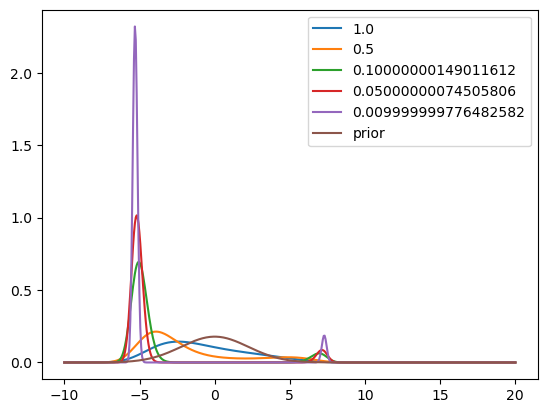

In [47]:
plt.plot(x_test.detach().numpy(),posterior_True.detach().numpy())
plt.plot(x_test.detach().numpy(),val_prior.detach().numpy())
plt.legend(l)

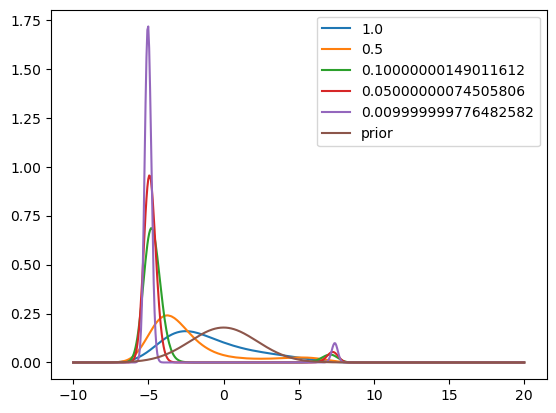

In [48]:
plt.plot(x_test.detach().numpy(),posterior_GPE.detach().numpy())
plt.plot(x_test.detach().numpy(),val_prior.detach().numpy())
plt.legend(l)

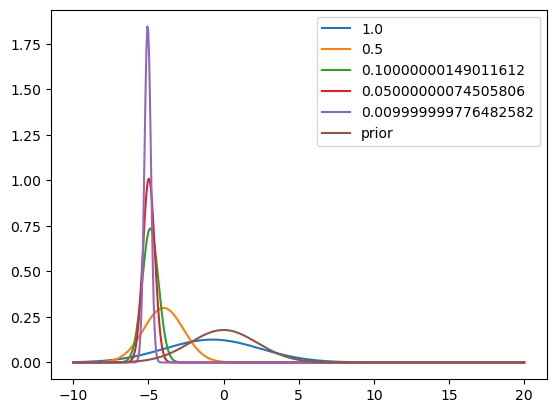

In [49]:
plt.plot(x_test.detach().numpy(),posterior_VI.detach().numpy())
plt.plot(x_test.detach().numpy(),val_prior.detach().numpy())
plt.legend(l)

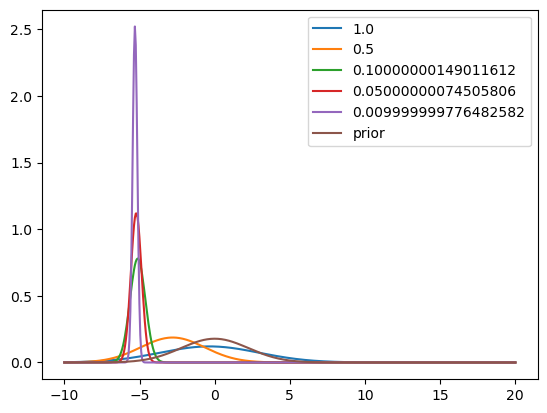

In [50]:
plt.plot(x_test.detach().numpy(),posterior_VI_fun.detach().numpy())
plt.plot(x_test.detach().numpy(),val_prior.detach().numpy())
plt.legend(l)

# $y=bx$

$y=bx+\epsilon$

$y|x \sim N(bx,\sigma^2)$

$x \sim N(\mu_0,\sigma_0^2)$

Then

$x|y \sim N(\mu_p,\sigma_p^2)$

where

$\mu_p = \frac{\sigma_0^2by+\sigma^2\mu_0}{\sigma_0^2b^2+\sigma^2}$

and

$\sigma_p^2 = \frac{2\sigma_0^2\sigma^2}{\sigma_0^2b^2+\sigma^2}$

In [51]:
p=3

In [52]:
rl = -10
ru=20

In [53]:
obs_error = 0.001

In [54]:
x=torch.linspace(rl,ru,p)

In [55]:
b=0.5

In [56]:
def lin(x):
    y = b*x
    return y

In [57]:
y = lin(x) 

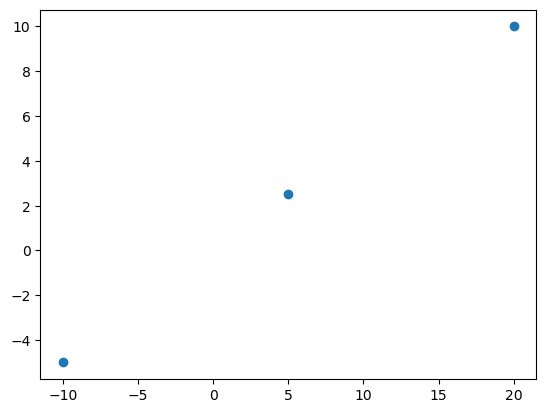

In [58]:
plt.plot(x.detach().numpy(),y.detach().numpy(),'o')

In [59]:
emulator = GPE.ensemble(x[:,None],y[:,None],mean_func="linear",training_iter=500)

0


In [60]:
tp = 500
dx = (ru-rl)/tp
x_test = torch.linspace(ru,rl,tp)


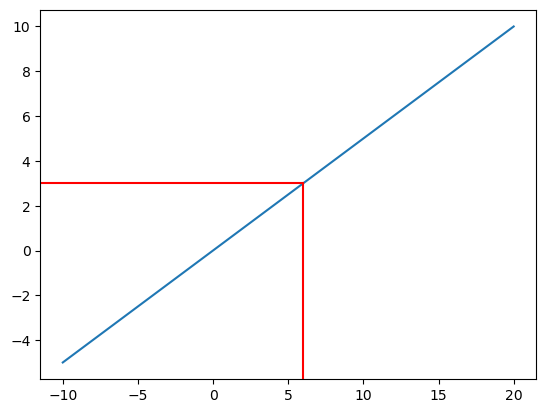

In [61]:
plt.plot(x_test,emulator.predict(x_test).detach().numpy())
plt.axhline(y=3, color='r', linestyle='-',xmax=0.53)
plt.axvline(x=6, color='r', linestyle='-',ymax=0.53)

In [62]:
prior_mean=torch.tensor([0])
prior_cov = torch.tensor([1])*torch.eye(1)
obs_error = torch.tensor([0.001])
y_cal = torch.tensor([3])

In [63]:
### initialize the variational parameters
m = torch.full((), 1.,dtype=dtype, requires_grad=True, device=device)
s2 = torch.full((1,),3.,dtype=dtype, requires_grad=True, device=device)


# Samples fixed here - but try adding them into the loop
nsamples = 1000
#Z = torch.randn((nsamples), dtype=dtype, requires_grad=False, device=device)

learning_rate = 1e-2
for t in range(1000):
    Z = torch.randn((nsamples), dtype=dtype, requires_grad=False, device=device)
    Z=Z[None,:]
    #negELBO = -Eloglike(m,log_s2)+KL(log_s2)
    
    negELBO = ELBO(m,s2,Z,emulator,y_cal[:,None],prior_mean,prior_cov,obs_error)
    
    if t % 100 == 99:
        print(t, negELBO.item(), 'm=', m.item(), 's2=', s2.pow(2).item())
    
    # Use autograd to compute the backward pass. This call will compute the
    # gradient of loss with respect to all Tensors with requires_grad=True.
    # After this call a.grad, b.grad. c.grad and d.grad will be Tensors holding
    # the gradient of the loss with respect to a, b, c, d respectively.
    negELBO.backward()

    # Manually update weights using gradient descent. Wrap in torch.no_grad()
    # because weights have requires_grad=True, but we don't need to track this
    # in autograd.
    with torch.no_grad():
        m -= learning_rate * m.grad
        s2 -= learning_rate * s2.grad
        
        # Manually zero the gradients after updating weights
        m.grad = None
        s2.grad = None
        
print(f'Result: p(x|y) = N({m.item()}, {torch.pow(s2,2).item()}) ')

99 4360.69140625 m= 5.951601028442383 s2= 61.77837371826172
199 31.21879768371582 m= 5.957568168640137 s2= 0.3325572907924652
299 10.867439270019531 m= 5.95381498336792 s2= 0.004293160047382116
399 11.037919998168945 m= 5.938349723815918 s2= 0.0158676840364933
499 11.402153968811035 m= 5.959062099456787 s2= 0.02157672867178917
599 12.11782169342041 m= 5.959324359893799 s2= 0.03956368565559387
699 12.26140022277832 m= 5.972078800201416 s2= 0.0001558186049805954
799 11.837945938110352 m= 5.955815315246582 s2= 0.0003605231468100101
899 23.727807998657227 m= 6.123908996582031 s2= 0.1843389868736267
999 12.466516494750977 m= 5.974445819854736 s2= 0.04161003977060318
Result: p(x|y) = N(5.9434123039245605, 0.0016803336329758167) 


In [64]:
dist = normal.Normal(loc=m, scale=s2)
val = torch.exp(dist.log_prob(x_test))

In [65]:
likelihood = torch.exp(emulator.ensemble_log_likelihood_obs_error(x_test,y_cal[:,None],obs_error))

In [66]:
prior_mean

tensor([0])

In [67]:
dist_prior = normal.Normal(loc=prior_mean, scale=torch.sqrt(torch.tensor([5])))
val_prior = torch.exp(dist_prior.log_prob(x_test))

In [82]:
obs_errors = torch.tensor([10,1,0.1,0.01,0.001])
posterior_GPE = torch.zeros((x_test.shape[0],obs_errors.shape[0]))
posterior_VI = torch.zeros((x_test.shape[0],obs_errors.shape[0]))
posterior_True = torch.zeros((x_test.shape[0],obs_errors.shape[0]))
posterior_Numerical = torch.zeros((x_test.shape[0],obs_errors.shape[0]))

In [83]:
for j,obs_error in enumerate(obs_errors):
    #result = minimize(ELBO, [1,1], args = (xx,emulator,y_test,prior_mean,prior_covar,x.columns,obs_error),method = 'Nelder-Mead',tol=1e-6)
    #var = scipy.stats.multivariate_normal(mean=(result.x[0]), cov=result.x[1]**2)
    #posterior_VI[:,j] = var.pdf(x_test)
    
    ### initialize the variational parameters
    m = torch.full((), 1.,dtype=dtype, requires_grad=True, device=device)
    s2 = torch.full((1,),3.,dtype=dtype, requires_grad=True, device=device)


    # Samples fixed here - but try adding them into the loop
    nsamples = 1000
    #Z = torch.randn((nsamples), dtype=dtype, requires_grad=False, device=device)

    learning_rate = 1e-2
    for t in range(1000):
        Z = torch.randn((nsamples), dtype=dtype, requires_grad=False, device=device)
        Z=Z[None,:]
        #negELBO = -Eloglike(m,log_s2)+KL(log_s2)

        negELBO = ELBO(m,s2,Z,emulator,y_cal[:,None],prior_mean,prior_cov,obs_error)

        if t % 100 == 99:
            print(t, negELBO.item(), 'm=', m.item(), 's2=', s2.pow(2).item())

        # Use autograd to compute the backward pass. This call will compute the
        # gradient of loss with respect to all Tensors with requires_grad=True.
        # After this call a.grad, b.grad. c.grad and d.grad will be Tensors holding
        # the gradient of the loss with respect to a, b, c, d respectively.
        negELBO.backward()

        # Manually update weights using gradient descent. Wrap in torch.no_grad()
        # because weights have requires_grad=True, but we don't need to track this
        # in autograd.
        with torch.no_grad():
            m -= learning_rate * m.grad
            s2 -= learning_rate * s2.grad

            # Manually zero the gradients after updating weights
            m.grad = None
            s2.grad = None

    print(f'Result: p(x|y) = N({m.item()}, {torch.pow(s2,2).item()}) ')
    
    dist = normal.Normal(loc=m, scale=s2)
    posterior_VI[:,j] = torch.exp(dist.log_prob(x_test))
    
    
    posterior_mean = (prior_cov/(prior_cov*(b**2)+obs_error))*b*y_cal
    posterior_cov = obs_error*prior_cov/(prior_cov*b**2 + obs_error)
    
    dist_posterior = normal.Normal(loc=posterior_mean, scale=np.sqrt(posterior_cov))
    posterior_True[:,j] = torch.exp(dist_posterior.log_prob(x_test))
    
    
    likelihood = torch.prod(torch.exp(emulator.ensemble_log_likelihood_obs_error(x_test,y_cal[:,None],obs_error)),axis=0)
    posterior_GPE[:,j] = likelihood*val_prior / (torch.sum(likelihood*val_prior)*dx)
    
    true_likelihood= f_likelihood(x_test,y_cal,lin,obs_error)
    true_likelihood=torch.exp(true_likelihood)
    posterior_Numerical[:,j] = (true_likelihood.squeeze()*val_prior / (torch.sum(true_likelihood.squeeze()*val_prior)*dx)).T
    
    print(j)
    
    

99 4.109880447387695 m= 0.45329928398132324 s2= 2.031651735305786
199 3.9464011192321777 m= 0.2562068998813629 s2= 1.110605239868164
299 3.9103426933288574 m= 0.18034496903419495 s2= 0.9862316250801086
399 3.915146827697754 m= 0.16054587066173553 s2= 0.9806097745895386
499 3.9112186431884766 m= 0.14862342178821564 s2= 0.9739587306976318
599 3.9414055347442627 m= 0.14422941207885742 s2= 0.9758487939834595
699 3.8733081817626953 m= 0.14896368980407715 s2= 0.9785605072975159
799 3.9075491428375244 m= 0.14894314110279083 s2= 0.976706326007843
899 3.9087934494018555 m= 0.1482669860124588 s2= 0.9880222678184509
999 3.911435604095459 m= 0.14568641781806946 s2= 0.9753726720809937
Result: p(x|y) = N(0.14561451971530914, 0.9750983715057373) 
0
99 3.806480884552002 m= 1.1365238428115845 s2= 1.471540093421936
199 3.6972103118896484 m= 1.1805331707000732 s2= 0.8526724576950073
299 3.7016711235046387 m= 1.1919444799423218 s2= 0.8049394488334656
399 3.7033605575561523 m= 1.196243405342102 s2= 0.79637

ValueError: Expected parameter scale (Tensor of shape (1,)) of distribution Normal(loc: tensor([5.9552], grad_fn=<ExpandBackward0>), scale: tensor([-0.0557], requires_grad=True)) to satisfy the constraint GreaterThan(lower_bound=0.0), but found invalid values:
tensor([-0.0557], requires_grad=True)

In [ ]:
l = obs_errors.tolist()
l.append('prior')

In [ ]:
plt.plot(x_test.detach().numpy(),posterior_Numerical.detach().numpy())
plt.plot(x_test.detach().numpy(),val_prior.detach().numpy())
plt.legend(l)

In [ ]:
plt.plot(x_test.detach().numpy(),posterior_True.detach().numpy())
plt.plot(x_test.detach().numpy(),val_prior.detach().numpy())
plt.legend(l)

In [ ]:
plt.plot(x_test.detach().numpy(),posterior_GPE.detach().numpy())
plt.plot(x_test.detach().numpy(),val_prior.detach().numpy())
plt.legend(l)

In [ ]:
plt.plot(x_test.detach().numpy(),posterior_VI.detach().numpy())
plt.plot(x_test.detach().numpy(),val_prior.detach().numpy())
plt.legend(l)

In [ ]:
ref = 2
plt.plot(x_test.detach().numpy(),posterior_True[:,ref].detach().numpy())
plt.plot(x_test.detach().numpy(),posterior_Numerical[:,ref].detach().numpy())
plt.plot(x_test.detach().numpy(),posterior_VI[:,ref].detach().numpy())
plt.plot(x_test.detach().numpy(),posterior_GPE[:,ref].detach().numpy())
plt.plot(x_test.detach().numpy(),val_prior.detach().numpy())
plt.legend(['true','numerical','VI','GPE','prior'])

In [ ]:
def acceptance(y,x,x_prime,sigma2): # Log acceptance for stability
    ratio = (-0.5*x_prime**2-0.5*(1/sigma2)*(b*x_prime-y)**2)-(-0.5*x**2-0.5*(1/sigma2)*(b*x-y)**2)
    alpha = np.min((0,ratio))
    return alpha

In [ ]:
acceptance(0,1,2,1)

In [ ]:
np.random.uniform()

In [ ]:
def metrop(y,x0,sigma2_mc,sigma2,iters):
    chain = np.zeros(iters+1) #Initialise markov chain
    chain[0]=x0 #set x0 as first element
    for i in range(iters):
        x = chain[i] #define x
        x_p = np.random.normal(chain[i],sigma2_mc) #select candidate value x'
        alpha = acceptance(y,x,x_p,sigma2) #calculate alpha
        u=np.random.uniform() #generate random uniform variable
        if np.log(u)<alpha: 
            chain[i+1]=x_p #accept candidate value
        else:
            chain[i+1]=x #reject candidate value
    return chain

In [ ]:
X = metrop(3,0,0.01,0.1,10000)

In [ ]:
plt.plot(X)

In [ ]:
plt.hist(X[2000::],density=True)
plt.plot(x_test.detach().numpy(),posterior_True[:,2].detach().numpy())
plt.plot(x_test.detach().numpy(),val_prior.detach().numpy())
plt.legend(['True Posterior','Prior','MCMC'])

# $z=ax^2+by^2$

In [ ]:
def ELBO(m,s2,x,emulator,y,prior_mean,prior_cov,obs_error):
    
    L=torch.zeros((x.shape[0],x.shape[0]))
    L=L.diagonal_scatter(s2)
    
    #L[1,0]=param[6]
   # L[2,0]=param[7]
   # L[2,1] =param[8]
    covar = L.matmul(L.T)
    z=L.matmul(x)+m
    
    z=z.T 
    
    mc_int = (emulator.ensemble_log_likelihood_obs_error(z,y,obs_error)+x_prior(z,prior_mean,prior_cov)[None]).mean()
        #mc_int +=-np.log(np.sum(((emulator.predict(z.iloc[[i]]).detach().numpy()-y.values)**2)))+np.log(x_prior(z.iloc[[i]],prior_mean,prior_cov))
        #mc_int += (np.sum(np.log(emulator.ensemble_likelihood(z.iloc[[i]],y)))+np.log(x_prior(z.iloc[[i]],prior_mean,prior_cov)))
    
    lb = mc_int - q_prior(covar)
    
    #print(mc_int/x.shape[1])
    #print(-q_prior(covar))
    #print(np.mean(z,axis=0))
    #print(-lb)
    return -lb
    

def ELBO_fun(m,s2,x,function,y,prior_mean,prior_cov,obs_error):
    
    L=torch.zeros((x.shape[0],x.shape[0]))
    L=L.diagonal_scatter(s2)
    
    #L[1,0]=param[6]
   # L[2,0]=param[7]
   # L[2,1] =param[8]
    covar = L.matmul(L.T)
    z=L.matmul(x)+m
   
    z=z.T
    
    lb = (f_likelihood(z.T,y,function,obs_error)+x_prior(z[None],prior_mean,prior_cov)).mean()- q_prior(covar)
        #mc_int +=-np.log(np.sum(((emulator.predict(z.iloc[[i]]).detach().numpy()-y.values)**2)))+np.log(x_prior(z.iloc[[i]],prior_mean,prior_cov))
        #mc_int += (np.sum(np.log(emulator.ensemble_likelihood(z.iloc[[i]],y)))+np.log(x_prior(z.iloc[[i]],prior_mean,prior_cov)))
    
    #print(mc_int/x.shape[1])
    #print(-q_prior(covar))
    #print(np.mean(z,axis=0))
    #print(-lb)
    return -lb

def x_prior(x,mean,cov):

    #var = scipy.stats.multivariate_normal(mean=mean, cov=cov)
    #val1 = var.pdf(x)
    dist = MultivariateNormal(loc=mean, covariance_matrix=cov)
    val = dist.log_prob(x)
    return val

def q_prior(covar):
    qp = -(covar.shape[0]/2)*(1+torch.log(torch.tensor(2*torch.pi)))-0.5*torch.log(torch.linalg.det(covar))
    return qp

def f_likelihood(x,y,f,sigma2):
    #x,f=emulator.normalise_test_data(x,f(x))
    #x,y=emulator.normalise_test_data(x,y)
    
    likelihood_manual=-0.5*((f(x) - y)**2)/(sigma2)- 0.5*torch.log(torch.tensor(2*np.pi))-0.5*torch.log(sigma2)
    return likelihood_manual

def f_likelihood2(x,y,f,sigma2):
    
    likelihood_manual=-0.5*((f(x) - y)**2)/(sigma2)- 0.5*np.log(2*np.pi)-0.5*np.log(sigma2)
    return likelihood_manual

In [ ]:
p=100 #points for plotting

In [ ]:
rl = -10 #lower bound
ru=10 #upper bound

In [ ]:
obs_error = 0.001 #observational error

In [ ]:
tp =20 #number of training points

In [ ]:
x=torch.linspace(rl,ru,p) #x for plotting
y=torch.linspace(rl,ru,p) #y for plotting

In [ ]:
a=0.1 #function parameters
b=0.3

In [ ]:
def quad_2(x): #ax^2 + by^2 function
    #z = -a*x[0]**2 + -b*x[1]**2+10
    z=3*x[0]+5*x[1]
    return z

In [ ]:
quad_2([0,0])

In [ ]:
X,Y=torch.meshgrid(x,y)

In [ ]:
zp= quad_2([X,Y]) #z for plotting

In [ ]:
zp.max()

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Plot the surface.
surf = ax.plot_surface(X, Y, zp,
                       linewidth=0, antialiased=False)

In [ ]:
y = torch.FloatTensor(tp).uniform_(-10, 10) #y training points (randomly sampled)


In [ ]:
x = torch.FloatTensor(tp).uniform_(-10, 10) #x training points (randomly sampled)

In [ ]:
z = quad_2([x,y]) #+ np.random.normal(0,obs_error,x.shape) # function evaluated at training points

In [ ]:
train_in = torch.stack((x,y)).T #convert to DF for emulator
train_out = z[:,None]

In [ ]:
train_in.shape

In [ ]:
emulator = GPE.ensemble(train_in,train_out,mean_func="constant",training_iter=500) #train emulator

In [ ]:
test_points = 1000 # number of test points
dx = (ru-rl)/test_points #distance between each test point (y and x axes equal)
x_test = torch.stack((X.reshape(p**2),Y.reshape(p**2))).T #test dataset


In [ ]:
x_test.shape

In [ ]:
emulator.predict(x_test).reshape(p,p)

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}) #visualise emulator over test

# Plot the surface.
surf = ax.plot_surface(X, Y, emulator.predict(x_test).detach().numpy().reshape(p,p),
                       linewidth=0, antialiased=False)

In [ ]:
prior_mean=torch.tensor([0,0])
prior_cov = torch.tensor([10,10])*torch.eye(2)
obs_error = torch.tensor(1)
y_cal = torch.tensor([10])

In [ ]:
prior_cov.shape

In [ ]:
dist_prior = MultivariateNormal(loc=prior_mean, covariance_matrix=prior_cov)
val_prior = torch.exp(dist_prior.log_prob(x_test))

plt.contourf(X,Y,val_prior.reshape(p,p))
plt.colorbar()

In [ ]:
Z = torch.randn((nsamples,2), dtype=dtype, requires_grad=False, device=device)

In [ ]:
Z.shape

In [ ]:
### initialize the variational parameters
m = torch.full((2,1), 10.,dtype=dtype, requires_grad=True, device=device)
s2 = torch.full((2,),1.,dtype=dtype , requires_grad=True, device=device)


# Samples fixed here - but try adding them into the loop
nsamples = 1000
#Z = torch.randn((nsamples), dtype=dtype, requires_grad=False, device=device)

learning_rate = 1e-2
for t in range(5000):
    Z = torch.randn((2,nsamples), dtype=dtype, requires_grad=False, device=device)
    #negELBO = -Eloglike(m,log_s2)+KL(log_s2)
    
    negELBO = ELBO_fun(m,s2,Z,quad_2,y_cal[:,None],prior_mean,prior_cov,obs_error)
    
    #if t % 100 == 99:
        #print(t, negELBO.item(), 'm=', m.item(), 's2=', s2.pow(2).item())
      #  print(m)
      #  print(s2)
      #   print(negELBO)
    # Use autograd to compute the backward pass. This call will compute the
    # gradient of loss with respect to all Tensors with requires_grad=True.
    # After this call a.grad, b.grad. c.grad and d.grad will be Tensors holding
    # the gradient of the loss with respect to a, b, c, d respectively.
    negELBO.backward()

    # Manually update weights using gradient descent. Wrap in torch.no_grad()
    # because weights have requires_grad=True, but we don't need to track this
    # in autograd.
    with torch.no_grad():

        m -= learning_rate * m.grad
        s2 -= learning_rate * s2.grad
        
        # Manually zero the gradients after updating weights
        m.grad = None
        s2.grad = None
        
#print(f'Result: p(x|y) = N({m.item()}, {torch.pow(s2,2).item()}) ')

In [ ]:
#establish VI posterior

dist = MultivariateNormal(loc=m.squeeze(), covariance_matrix=torch.eye(2)*(s2**2))
val= torch.exp(dist.log_prob(x_test))


#var_prior = scipy.stats.multivariate_normal(mean=m.squeeze().detach().numpy(), cov=(torch.eye(2)*(s2**2)).detach().numpy())
#val = var_prior.pdf(x_test.detach().numpy())

plt.contourf(X.detach().numpy(),Y.detach().numpy(),val.reshape(p,p).detach().numpy())
plt.colorbar()

In [ ]:
### initialize the variational parameters
m = torch.full((2,1), 10.,dtype=dtype, requires_grad=True, device=device)
s2 = torch.full((2,),1.,dtype=dtype , requires_grad=True, device=device)


# Samples fixed here - but try adding them into the loop
nsamples = 1000
#Z = torch.randn((nsamples), dtype=dtype, requires_grad=False, device=device)

learning_rate = 1e-2
for t in range(5000):
    Z = torch.randn((2,nsamples), dtype=dtype, requires_grad=False, device=device)
    #negELBO = -Eloglike(m,log_s2)+KL(log_s2)
    
    negELBO = ELBO(m,s2,Z,emulator,y_cal[:,None],prior_mean,prior_cov,obs_error)
    
    #if t % 100 == 99:
        #print(t, negELBO.item(), 'm=', m.item(), 's2=', s2.pow(2).item())
      #  print(m)
      #  print(s2)
      #   print(negELBO)
    # Use autograd to compute the backward pass. This call will compute the
    # gradient of loss with respect to all Tensors with requires_grad=True.
    # After this call a.grad, b.grad. c.grad and d.grad will be Tensors holding
    # the gradient of the loss with respect to a, b, c, d respectively.
    negELBO.backward()

    # Manually update weights using gradient descent. Wrap in torch.no_grad()
    # because weights have requires_grad=True, but we don't need to track this
    # in autograd.
    with torch.no_grad():

        m -= learning_rate * m.grad
        s2 -= learning_rate * s2.grad
        
        # Manually zero the gradients after updating weights
        m.grad = None
        s2.grad = None
        
#print(f'Result: p(x|y) = N({m.item()}, {torch.pow(s2,2).item()}) ')

In [ ]:
#establish VI posterior

dist = MultivariateNormal(loc=m.squeeze(), covariance_matrix=torch.eye(2)*(s2**2))
val= torch.exp(dist.log_prob(x_test))


#var_prior = scipy.stats.multivariate_normal(mean=m.squeeze().detach().numpy(), cov=(torch.eye(2)*(s2**2)).detach().numpy())
#val = var_prior.pdf(x_test.detach().numpy())

plt.contourf(X.detach().numpy(),Y.detach().numpy(),val.reshape(p,p).detach().numpy())
plt.colorbar()

In [ ]:
m

In [ ]:
s2**2

In [ ]:
obs_error

In [ ]:
likelihood = torch.exp(emulator.ensemble_log_likelihood_obs_error(x_test,y_cal[:,None],obs_error)) #Generate likelihood from GP

In [ ]:
posterior = likelihood*val_prior / (torch.sum(likelihood*val_prior)*dx*dx) #Generate posterior from GP

In [ ]:
plt.contourf(X.detach().numpy(),Y.detach().numpy(),likelihood.reshape(p,p).detach().numpy()) #Visualise likelihood
plt.colorbar()

In [ ]:
plt.contourf(X,Y,posterior.reshape(p,p).detach().numpy()) #visualise posterior
plt.colorbar()

In [ ]:
true_likelihood= f_likelihood([X,Y],y_cal[:,None],quad_2,obs_error) #Generate numerical log likelihood

In [ ]:
plt.contourf(X,Y,true_likelihood.reshape(p,p).detach().numpy(),levels=1000) #visualise numerical likelihood

plt.colorbar()

In [ ]:
true_likelihood=torch.exp(true_likelihood) #Generate numerical likelihood

In [ ]:
plt.contourf(X,Y,true_likelihood.reshape(p,p).detach().numpy()) #visualise numerical likelihood
plt.colorbar()

In [ ]:
#calculate numerical posterior
true_posterior = true_likelihood.squeeze()*val_prior.reshape(p,p) / (torch.sum(true_likelihood.squeeze()*val_prior.reshape(p,p))*0.2)

In [ ]:
plt.contourf(X,Y,true_posterior.reshape(p,p).detach().numpy()) #visualise numerical posterior
plt.colorbar()

In [ ]:
plt.contourf(X,Y,true_likelihood.reshape(p,p).detach().numpy()) #visualise numerical likelihood
plt.colorbar()

In [ ]:
#numerical likelihood in 3D
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Plot the surface.
surf = ax.plot_surface(X, Y,true_likelihood.reshape(p,p))

# EP Data

In [ ]:
x_labels=pd.read_csv('/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/input/xlabels_EP.txt',delim_whitespace=True,header=None)
inputOrig = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/input/X_EP.txt',index_col=None,delim_whitespace=True,header=None)
inputOrig.columns=x_labels
print(inputOrig)

In [ ]:
y_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/output/ylabels.txt',delim_whitespace=True,header=None)
outputOrig = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/output/Y.txt',index_col=None,delim_whitespace=True,header=None)
outputOrig.columns=y_labels
print(outputOrig)

In [ ]:
inputOrig.iloc[:,[0,2,3]]

In [ ]:
# split original dataset in training, validation and testing sets
X=torch.tensor(inputOrig.iloc[:,[0,2,3]].values)
y=torch.tensor(outputOrig.values)
x_train, x_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=1,
    random_state=seed
)

In [ ]:
nDim = x_train.shape[1]
boundsMaxMin = []
for i in range(nDim):
    boundsMaxMin.append([torch.min(x_train[:,i]),torch.max(x_train[:,i])])
    print(boundsMaxMin[i])

In [ ]:
centre = (np.array(boundsMaxMin)[:,1]+np.array(boundsMaxMin)[:,0])/2

In [ ]:
p=centre.tolist()
p=p+(torch.ones(x_train.shape[1]).tolist())

In [ ]:
obs_error=0.001

In [ ]:
p

In [ ]:
emulator = GPE.ensemble(x_train,y_train,mean_func="linear",training_iter=500)

In [ ]:
x_train.shape[1]

In [ ]:
prior_covar

In [ ]:
prior_mean

In [ ]:
prior_covar = torch.eye(x_train.shape[1]) #prior covariance and mean
prior_mean=torch.tensor(centre)
obs_error = torch.tensor([0.001])

In [ ]:
L=torch.zeros((x.shape[0],x.shape[0]))
L=L.diagonal_scatter(s2)

In [ ]:
L

In [ ]:
covar = L.matmul(L.T)
z=L.matmul(Z)+m
    
z=z.T 

In [ ]:
z

In [ ]:
### initialize the variational parameters
m = torch.full((3,1), 0.,dtype=dtype, requires_grad=True, device=device)
s2 = torch.full((3,),1.,dtype=dtype , requires_grad=True, device=device)


# Samples fixed here - but try adding them into the loop
nsamples = 1000
#Z = torch.randn((nsamples), dtype=dtype, requires_grad=False, device=device)

learning_rate = 1e-2
for t in range(10000):
    Z = torch.randn((3,nsamples), dtype=dtype, requires_grad=False, device=device)
    #negELBO = -Eloglike(m,log_s2)+KL(log_s2)
    
    negELBO = ELBO(m,s2,Z,emulator,y_test,prior_mean,prior_covar,obs_error)
    
    if t % 100 == 99:
        print(t,negELBO.item(),'m=',m)
        #print(t, negELBO.item(), 'm=', m.item(), 's2=', s2.pow(2).item())
      #  print(m)
      #  print(s2)
      #   print(negELBO)
    # Use autograd to compute the backward pass. This call will compute the
    # gradient of loss with respect to all Tensors with requires_grad=True.
    # After this call a.grad, b.grad. c.grad and d.grad will be Tensors holding
    # the gradient of the loss with respect to a, b, c, d respectively.
    negELBO.backward()

    # Manually update weights using gradient descent. Wrap in torch.no_grad()
    # because weights have requires_grad=True, but we don't need to track this
    # in autograd.
    with torch.no_grad():

        m -= learning_rate * m.grad
        s2 -= learning_rate * s2.grad
        
        # Manually zero the gradients after updating weights
        m.grad = None
        s2.grad = None
        
#print(f'Result: p(x|y) = N({m.item()}, {torch.pow(s2,2).item()}) ')

In [ ]:
boundsMaxMin=torch.tensor(boundsMaxMin)

In [ ]:
m

In [ ]:
x_test

In [ ]:
Nx=30

In [ ]:
X=torch.linspace(boundsMaxMin[1,0],boundsMaxMin[1,1],Nx)

In [ ]:
dist = MultivariateNormal(loc=m[2], covariance_matrix=torch.eye(1)*s2[2,None]**2)
val = torch.exp(dist.log_prob(X[:,None]))

In [ ]:
plt.plot(X.detach().numpy(),val.detach().numpy())

In [ ]:
Nx=30

In [ ]:
X=torch.linspace(boundsMaxMin[0,0],boundsMaxMin[0,1],Nx)
Y=np.linspace(boundsMaxMin[1,0],boundsMaxMin[1,1],Nx)
Z=np.linspace(boundsMaxMin[2,0],boundsMaxMin[2,1],Nx)

In [ ]:
g = np.meshgrid(X,Y,Z,indexing='ij')
positions = pd.DataFrame(np.vstack(map(np.ravel, g)).T)
positions.columns = x_test.columns

In [ ]:
var = scipy.stats.multivariate_normal(mean=(result.x[0:x_train.shape[1]]), cov=np.identity(x_train.shape[1])*result.x[x_train.shape[1]:2*x_train.shape[1]]**2)
val = var.pdf(positions).reshape(Nx,Nx,Nx)

In [ ]:
plt.plot(X,np.sum(val,axis=(1,2)))
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off
plt.xlabel('a_ventricles')
plt.axvline(x = x_test.iloc[0,0], color = 'r', label = 'axvline - full height')

In [ ]:
x_test

In [ ]:
plt.plot(Y,np.sum(val,axis=(0,2)))
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off
plt.xlabel('a_ventricles')
plt.axvline(x = x_test.iloc[0,1], color = 'r', label = 'axvline - full height')

In [ ]:
plt.plot(Z,np.sum(val,axis=(1,0)))
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off
plt.xlabel('a_ventricles')
plt.axvline(x = x_test.iloc[0,2], color = 'r', label = 'axvline - full height')

In [ ]:
likelihood = np.exp(np.sum(emulator.ensemble_log_likelihood_obs_error(positions,y_test,obs_error),axis=0)).reshape(Nx,Nx,Nx)#Generate likelihood from GP

In [ ]:
val_prior = var_prior.pdf(positions).reshape(Nx,Nx,Nx)

In [ ]:
posterior=(likelihood*val_prior)/(np.sum(likelihood*val_prior)*())

In [ ]:
plt.plot(X,np.sum(posterior,axis=(1,0)))

In [ ]:
np.sum(np.sum(emulator.ensemble_log_likelihood_obs_error(positions,y_test,obs_error),axis=0).reshape(Nx,Nx,Nx),axis=(0,1))

In [ ]:
emulator.ensemble_log_likelihood_obs_error(positions,y_test,obs_error)